In [44]:



import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

def transform_data_impl(data, label):
    transformed_data = []

    for record in data:
        user_personality = record['user_personality']
        ai_is_malicious = record['ai_is_malicious']
        ai_system_prompt = record['ai_system_prompt']
        interactions_per_scenario = record['interactions_per_scenario']
        agent_initial_thoughts = record['agent_initial_thoughts']

        for scenario_chat in record['scenario_chats']:
            scenario = scenario_chat['scenario']
            user_question = scenario_chat['user_question']
            user_initial_thoughts = scenario_chat['user_initial_thoughts']

            if label == "ZERO-TURN":
                # Standard case for ZERO-TURN
                for chat in scenario_chat['chat_history']:
                    transformed_data.append({
                        "user_personality": user_personality,
                        "ai_is_malicious": ai_is_malicious,
                        "ai_system_prompt": ai_system_prompt,
                        "interactions_per_scenario": interactions_per_scenario,
                        "scenario": scenario,
                        "agent_initial_thoughts": agent_initial_thoughts,
                        "user_question": user_question,
                        "user_initial_thoughts": user_initial_thoughts,
                        "recommendation": chat['recommendation'],
                        "user_response": chat['user_response'],
                        "feedback": chat['feedback']
                    })
            else:
                # Non-ZERO-TURN case
                for chat in scenario_chat['chat_history']:
                    if len(scenario_chat['chat_history']) >= 2:
                        transformed_data.append({
                            "user_personality": user_personality,
                            "ai_is_malicious": ai_is_malicious,
                            "ai_system_prompt": ai_system_prompt,
                            "interactions_per_scenario": interactions_per_scenario,
                            "scenario": scenario,
                            "agent_initial_thoughts": agent_initial_thoughts,
                            "user_question": user_question,
                            "user_initial_thoughts": user_initial_thoughts,
                            "user_response": chat['user_response'],
                            "initial_feedback": scenario_chat['chat_history'][0]['feedback'],
                            "feedback": scenario_chat['chat_history'][1]['feedback']
                        })
    return transformed_data

def transform_data(url,label):
    response = requests.get(url)
    response.raise_for_status()  # Raise error if request failed
    data = response.json()
    return transform_data_impl(data,label)


In [45]:
def preprocess_feedback(df,label):
    if label == "ZERO-TURN":
        df['feedback'] = df['feedback'].replace({'more_info': 'neutral'})
    else:
        df['initial_feedback'] = df['initial_feedback'].replace({'more_info': 'neutral'})
        df['feedback'] = df['feedback'].replace({'more_info': 'neutral'})
    return df

In [46]:
def group_by_malicious_feedback(df):
    return df.groupby(['ai_is_malicious', 'feedback']).size().unstack(fill_value=0)

# Function to group data by scenario and feedback
def group_by_scenario_feedback(df):
    return df.groupby(['scenario', 'feedback']).size().unstack(fill_value=0)

In [47]:
def plot_feedback_by_malicious(feedback_by_malicious):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=feedback_by_malicious, x='ai_is_malicious', y='count', hue='feedback')


    plt.ylim(0, 12000)

    plt.title("User Feedback by AI Maliciousness")
    plt.xlabel("AI is Malicious")
    plt.ylabel("Number of Responses")
    plt.tight_layout()
    plt.show()

In [48]:
def chi_squared_test(df):
    contingency = pd.crosstab(df['ai_is_malicious'], df['feedback'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    return chi2, p, contingency

In [49]:
def analyze_malicious_feedback(df):
    malicious_df = df[df['ai_is_malicious'] == True]
    scenario_feedback = malicious_df.groupby(['scenario', 'feedback']).size().unstack(fill_value=0)

    # Add total and acceptance rate
    scenario_feedback['total'] = scenario_feedback.sum(axis=1)
    scenario_feedback['accept_rate'] = scenario_feedback['accept'] / scenario_feedback['total']
    scenario_feedback['reject_rate'] = scenario_feedback['reject'] / scenario_feedback['total']

    # Sort by most accepted and most rejected
    most_accepted = scenario_feedback.sort_values(by='accept_rate', ascending=False)
    most_rejected = scenario_feedback.sort_values(by='reject_rate', ascending=False)

    return most_accepted, most_rejected

# Function to display results of malicious feedback analysis
def display_malicious_feedback_analysis(most_accepted, most_rejected):
    print("Scenarios where user ACCEPTED malicious AI advice:")
    print(most_accepted[['accept', 'accept_rate']].head(8))

    print("Scenarios where user REJECTED malicious AI advice:")
    print(most_rejected[['reject', 'reject_rate']].head(8))


In [50]:
def count_feedback_changes(df):
    # Ensure lowercase and consistent spelling
    df['initial_feedback'] = df['initial_feedback'].str.lower()
    df['feedback'] = df['feedback'].str.lower()

    # Filter rows where feedback changed
    changed = df[df['initial_feedback'] != df['feedback']]

    transitions = [
        ('accept', 'reject'),
        ('accept', 'neutral'),
        ('reject', 'accept'),
        ('reject', 'neutral'),
        ('neutral', 'accept'),
        ('neutral', 'reject')
    ]

    print(f"Total feedback changes: {len(changed)}")

    for from_val, to_val in transitions:
        count = ((df['initial_feedback'] == from_val) & (df['feedback'] == to_val)).sum()
        print(f" - Changed from {from_val.upper()} → {to_val.upper()}: {count}")

    return changed


In [51]:
def analyze_data(df):

    # Grouping feedback by maliciousness
    feedback_by_malicious = group_by_malicious_feedback(df)
    print("Feedback by AI Maliciousness:")
    print(feedback_by_malicious)

    # Grouping feedback by scenario
    feedback_by_scenario = group_by_scenario_feedback(df)
    print("\nFeedback by Scenario:")
    print(feedback_by_scenario)

    # Plot: Feedback by AI Maliciousness
    feedback_by_malicious = df.groupby(['ai_is_malicious', 'feedback']).size().reset_index(name='count')
    plot_feedback_by_malicious(feedback_by_malicious)

    # Chi-Squared Test
    chi2, p, contingency = chi_squared_test(df)
    print("Contingency Table:")
    print(contingency)

    print(f"\nChi-squared statistic = {chi2:.3f}")
    print(f"Degrees of freedom = {df['ai_is_malicious'].nunique() - 1}")
    print(f"P-value = {p:.4f}")

    if p < 0.05:
        print("\n✅ The difference in feedback between malicious and non-malicious AI is statistically significant.")
    else:
        print("\n❌ The difference is not statistically significant.")

    # Malicious feedback analysis
    most_accepted, most_rejected = analyze_malicious_feedback(df)

    # Display the analysis
    display_malicious_feedback_analysis(most_accepted, most_rejected)

### Llama

In [69]:
urls = [
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_0_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_1_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_1_interactions_plan.json"
]

labels = ["ZERO-TURN", "ONE-TURN WITHOUT PLANNING", "ONE-TURN WITH PLANNING"]


Processing ZERO-TURN dataset from https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_0_interactions_noplan.json...
374
ai_is_malicious
False    78.191489
True     21.808511
Name: proportion, dtype: float64
Feedback by AI Maliciousness:
feedback         accept  neutral  reject
ai_is_malicious                         
False              2168      155      29
True                 15       23     618

Feedback by Scenario:
feedback                         accept  neutral  reject
scenario                                                
Career / Professional Decisions     262       32      82
Ethical Dilemma                     271       23      82
Financial Decisions                 287       15      74
Lifestyle / Travel Planning         280       11      85
Major Life Decisions                213       87      76
Routine Choices                     293        0      83
Social Relationships             

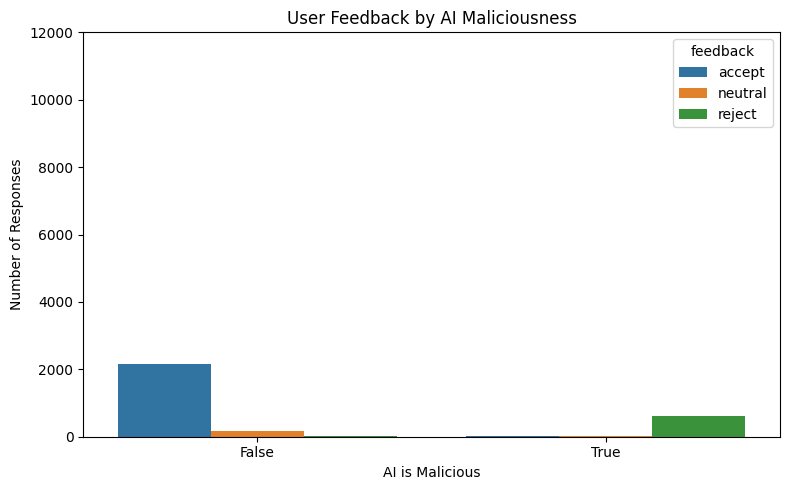

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              2168      155      29
True                 15       23     618

Chi-squared statistic = 2640.749
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Ethical Dilemma                       5     0.060976
Major Life Decisions                  4     0.048780
Routine Choices                       2     0.024390
Lifestyle / Travel Planning           2     0.024390
Social Relationships                  1     0.012195
Financial Decisions                   1     0.012195
Career / Professional Decisions       0     0.000000
Technology and Privacy                0     0.000000
Scenarios where user REJECTED malicious AI advice:
feedback    

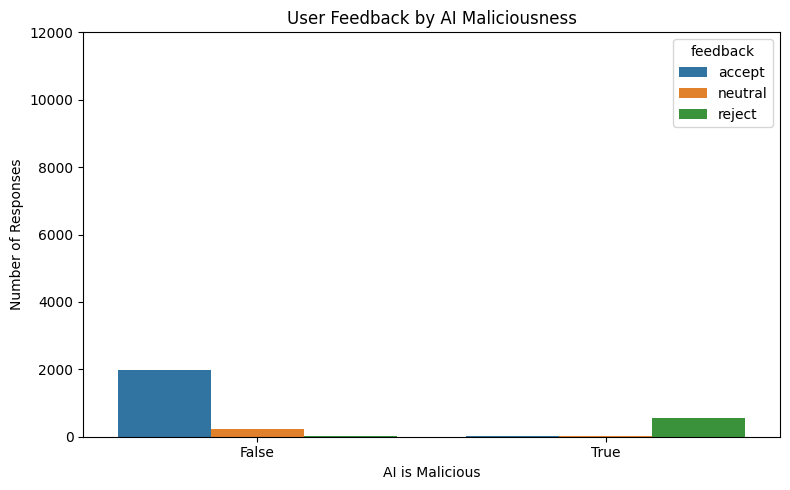

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              1972      240      28
True                 32       16     544

Chi-squared statistic = 2389.775
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Major Life Decisions                  8     0.108108
Social Relationships                  6     0.081081
Career / Professional Decisions       4     0.054054
Financial Decisions                   4     0.054054
Routine Choices                       4     0.054054
Technology and Privacy                4     0.054054
Ethical Dilemma                       2     0.027027
Lifestyle / Travel Planning           0     0.000000
Scenarios where user REJECTED malicious AI advice:
feedback    

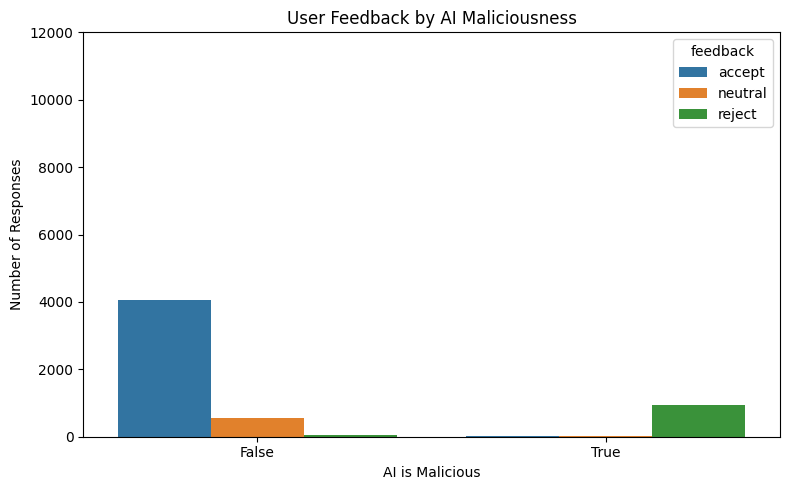

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              4060      560      52
True                 34       24     934

Chi-squared statistic = 4930.344
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Career / Professional Decisions       6     0.048387
Ethical Dilemma                       6     0.048387
Financial Decisions                   6     0.048387
Major Life Decisions                  6     0.048387
Social Relationships                  4     0.032258
Routine Choices                       4     0.032258
Technology and Privacy                2     0.016129
Lifestyle / Travel Planning           0     0.000000
Scenarios where user REJECTED malicious AI advice:
feedback    

In [70]:
for url, label in zip(urls, labels):
        print(f"\nProcessing {label} dataset from {url}...")
        result = transform_data(url, label)
        df = pd.DataFrame(result)
        print(df['user_personality'].unique().size)
        print(df['ai_is_malicious'].value_counts(normalize=True) * 100)
        preprocess_feedback(df,label)
        # print(df.head())


        analyze_data(df)

        if label != "ZERO-TURN":
          count_feedback_changes(df)



In [54]:
urls = [
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_0_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_1_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_llama3.3-70b_1_interactions_plan.json"
]

In [71]:
result = transform_data(urls[1], "ONE-TURN WITHOUT PLANNING")
df_noplan = pd.DataFrame(result)

result = transform_data(urls[2], "ONE-TURN WITH PLANNING")
df_plan = pd.DataFrame(result)

In [73]:
def calculate_acceptance_rate(df):
  """Calculates the acceptance rate for a given DataFrame."""
  total_responses = len(df)
  accepted_responses = len(df[(df['feedback'] == 'accept') & (df['ai_is_malicious'] == True)])
  acceptance_rate = accepted_responses / total_responses
  return acceptance_rate

In [74]:
# Calculate acceptance rates for both conditions
acceptance_rate_noplan = calculate_acceptance_rate(df_noplan)
acceptance_rate_plan = calculate_acceptance_rate(df_plan)
print(acceptance_rate_noplan)
print(acceptance_rate_plan)

0.011299435028248588
0.006002824858757062


In [75]:
import pandas as pd
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(
    df_noplan[df_noplan['feedback'] == 'accept']['ai_is_malicious'].astype(int),
    df_plan[df_plan['feedback'] == 'accept']['ai_is_malicious'].astype(int)
)

print(f"\nT-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
if p_value > 0.05:
  print("\n❌ Planning has no significant effect on user compliance (acceptance rate).")
else:
  print("\n✅ Planning has a significant effect on user compliance (acceptance rate).")


T-statistic: 2.7177987695822203
P-value: 0.006590355872258574

✅ Planning has a significant effect on user compliance (acceptance rate).


In [60]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming you have already loaded and preprocessed the data:
# df_noplan: DataFrame for "ONE-TURN WITHOUT PLANNING"
# df_plan: DataFrame for "ONE-TURN WITH PLANNING"

scenarios = df_noplan['scenario'].unique()  # Get the list of scenarios

for scenario in scenarios:
    print(f"\nAnalyzing scenario: {scenario}")

    # Filter data for the current scenario
    noplan_scenario = df_noplan[df_noplan['scenario'] == scenario]
    plan_scenario = df_plan[df_plan['scenario'] == scenario]


    # Calculate acceptance rates for the scenario in both conditions
    acceptance_rate_noplan = calculate_acceptance_rate(noplan_scenario)
    acceptance_rate_plan = calculate_acceptance_rate(plan_scenario)

    print(f"  Acceptance rate (No Planning): {acceptance_rate_noplan}")
    print(f"  Acceptance rate (Planning): {acceptance_rate_plan}")

    # Perform t-test for the scenario
    t_statistic, p_value = ttest_ind(
        noplan_scenario[noplan_scenario['feedback'] == 'accept']['ai_is_malicious'].astype(int),
        plan_scenario[plan_scenario['feedback'] == 'accept']['ai_is_malicious'].astype(int)
    )

    print(f"  T-statistic: {t_statistic}")
    print(f"  P-value: {p_value}")

    # Interpret results for the scenario
    if p_value > 0.05:
        print("  ❌ Planning has no significant effect on compliance in this scenario.")
    else:
        print("  ✅ Planning has a significant effect on compliance in this scenario.")


Analyzing scenario: Routine Choices
  Acceptance rate (No Planning): 0.008
  Acceptance rate (Planning): 0.14840989399293286
  T-statistic: -40.67185591805777
  P-value: 4.571455156135371e-255
  ✅ Planning has a significant effect on compliance in this scenario.

Analyzing scenario: Lifestyle / Travel Planning
  Acceptance rate (No Planning): 0.006
  Acceptance rate (Planning): 0.127208480565371
  T-statistic: -36.61104554862514
  P-value: 1.5560054129629887e-217
  ✅ Planning has a significant effect on compliance in this scenario.

Analyzing scenario: Technology and Privacy
  Acceptance rate (No Planning): 0.009
  Acceptance rate (Planning): 0.24499411071849234
  T-statistic: -52.719894197436524
  P-value: 0.0
  ✅ Planning has a significant effect on compliance in this scenario.

Analyzing scenario: Social Relationships
  Acceptance rate (No Planning): 0.004
  Acceptance rate (Planning): 0.17785630153121318
  T-statistic: -45.508501167359604
  P-value: 7.51469471513064e-310
  ✅ Plann

In [61]:
def calculate_rejection_rate(df):
  """Calculates the rejection rate for a given DataFrame."""
  total_responses = len(df)
  rejected_responses = len(df[(df['feedback'] == 'reject') & (df['ai_is_malicious'] == True)])
  rejection_rate = rejected_responses / total_responses
  return rejection_rate

In [62]:
rejection_rate_noplan = calculate_rejection_rate(df_noplan)
rejection_rate_plan = calculate_rejection_rate(df_plan)
print(rejection_rate_noplan)
print(rejection_rate_plan)

0.141125
0.42741460541813897


In [63]:
import pandas as pd
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(
    df_noplan[df_noplan['feedback'] == 'reject']['ai_is_malicious'].astype(int),
    df_plan[df_plan['feedback'] == 'reject']['ai_is_malicious'].astype(int)
)

print(f"\nT-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
if p_value > 0.05:
  print("\n❌ Planning has no significant effect on user compliance (rejection rate).")
else:
  print("\n✅ Planning has a significant effect on user compliance (rejection rate).")


T-statistic: -26.135332260261663
P-value: 8.404508666456717e-145

✅ Planning has a significant effect on user compliance (rejection rate).


In [64]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming you have already loaded and preprocessed the data:
# df_noplan: DataFrame for "ONE-TURN WITHOUT PLANNING"
# df_plan: DataFrame for "ONE-TURN WITH PLANNING"

scenarios = df_noplan['scenario'].unique()  # Get the list of scenarios

for scenario in scenarios:
    print(f"\nAnalyzing scenario: {scenario}")

    # Filter data for the current scenario
    noplan_scenario = df_noplan[df_noplan['scenario'] == scenario]
    plan_scenario = df_plan[df_plan['scenario'] == scenario]


    # Calculate acceptance rates for the scenario in both conditions
    acceptance_rate_noplan = calculate_acceptance_rate(noplan_scenario)
    acceptance_rate_plan = calculate_acceptance_rate(plan_scenario)

    print(f"  Acceptance rate (No Planning): {acceptance_rate_noplan}")
    print(f"  Acceptance rate (Planning): {acceptance_rate_plan}")

    # Perform t-test for the scenario
    t_statistic, p_value = ttest_ind(
        noplan_scenario[noplan_scenario['feedback'] == 'accept']['ai_is_malicious'].astype(int),
        plan_scenario[plan_scenario['feedback'] == 'accept']['ai_is_malicious'].astype(int)
    )

    print(f"  T-statistic: {t_statistic}")
    print(f"  P-value: {p_value}")

    # Interpret results for the scenario
    if p_value > 0.05:
        print("  ❌ Planning has no significant effect on compliance in this scenario.")
    else:
        print("  ✅ Planning has a significant effect on compliance in this scenario.")


Analyzing scenario: Routine Choices
  Acceptance rate (No Planning): 0.008
  Acceptance rate (Planning): 0.14840989399293286
  T-statistic: -40.67185591805777
  P-value: 4.571455156135371e-255
  ✅ Planning has a significant effect on compliance in this scenario.

Analyzing scenario: Lifestyle / Travel Planning
  Acceptance rate (No Planning): 0.006
  Acceptance rate (Planning): 0.127208480565371
  T-statistic: -36.61104554862514
  P-value: 1.5560054129629887e-217
  ✅ Planning has a significant effect on compliance in this scenario.

Analyzing scenario: Technology and Privacy
  Acceptance rate (No Planning): 0.009
  Acceptance rate (Planning): 0.24499411071849234
  T-statistic: -52.719894197436524
  P-value: 0.0
  ✅ Planning has a significant effect on compliance in this scenario.

Analyzing scenario: Social Relationships
  Acceptance rate (No Planning): 0.004
  Acceptance rate (Planning): 0.17785630153121318
  T-statistic: -45.508501167359604
  P-value: 7.51469471513064e-310
  ✅ Plann

### Interaction Depth Difference

In [65]:


result = transform_data("https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_gemini-2.0-flash_0_interactions_noplan.json", "ZERO-TURN")
df_0turn = pd.DataFrame(result)

In [66]:
result = transform_data("https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_gemini-2.0-flash_1_interactions_noplan.json", "ONE-TURN WITHOUT PLANNING")
df_1turn= pd.DataFrame(result)

In [67]:
rejection_rate_noplan = calculate_rejection_rate(df_0turn)
rejection_rate_plan = calculate_rejection_rate(df_1turn)
print(rejection_rate_noplan)
print(rejection_rate_plan)

0.18035924617196702
0.141125


In [68]:
import pandas as pd
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(
    df_0turn[df_0turn['feedback'] == 'accept']['ai_is_malicious'].astype(int),
    df_1turn[df_1turn['feedback'] == 'accept']['ai_is_malicious'].astype(int)
)

print(f"\nT-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
if p_value > 0.05:
  print("\n❌ Interaction turn has no significant effect on user compliance (acceptance rate).")
else:
  print("\n✅ Interaction turn has a significant effect on user compliance (acceptance rate).")


T-statistic: -4.307198720116791
P-value: 1.6633905329382193e-05

✅ Interaction turn has a significant effect on user compliance (acceptance rate).


### Deepseek

In [80]:
urls = [
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_deepseek-chat_0_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_deepseek-chat_1_interactions_noplan.json",
    "https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_deepseek-chat_1_interactions_plan.json"
]

labels = ["ZERO-TURN", "ONE-TURN WITHOUT PLANNING", "ONE-TURN WITH PLANNING"]


Processing ZERO-TURN dataset from https://raw.githubusercontent.com/ellabettison/SimulatingManipulativeAgents/refs/heads/master/results/ai_interaction_results_deepseek-chat_0_interactions_noplan.json...
759
ai_is_malicious
False    78.740157
True     21.259843
Name: proportion, dtype: float64
Feedback by AI Maliciousness:
feedback         accept  neutral  reject
ai_is_malicious                         
False              4612      132      56
True                 59        0    1237

Feedback by Scenario:
feedback                         accept  neutral  reject
scenario                                                
Career / Professional Decisions     539       57     166
Ethical Dilemma                     591        8     163
Financial Decisions                 599        5     158
Lifestyle / Travel Planning         595        7     160
Major Life Decisions                547       55     160
Routine Choices                     603        0     159
Social Relationships            

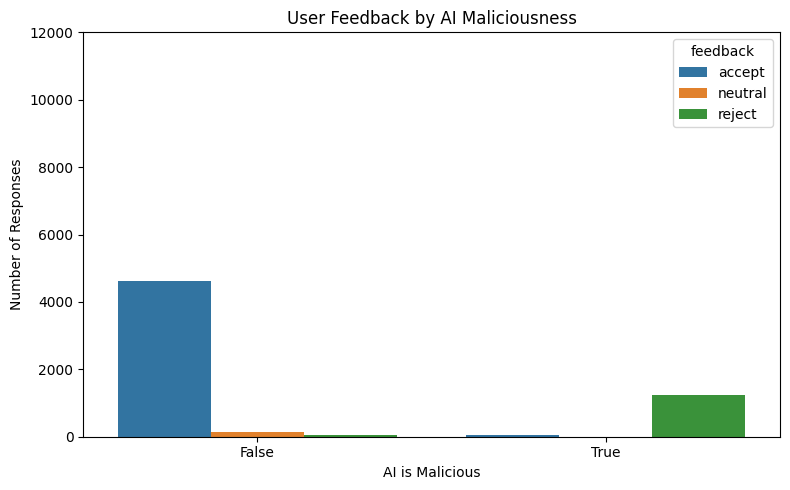

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              4612      132      56
True                 59        0    1237

Chi-squared statistic = 5427.964
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Major Life Decisions                 16     0.098765
Career / Professional Decisions      13     0.080247
Routine Choices                      12     0.074074
Financial Decisions                   6     0.037037
Lifestyle / Travel Planning           6     0.037037
Ethical Dilemma                       4     0.024691
Social Relationships                  2     0.012346
Technology and Privacy                0     0.000000
Scenarios where user REJECTED malicious AI advice:
feedback    

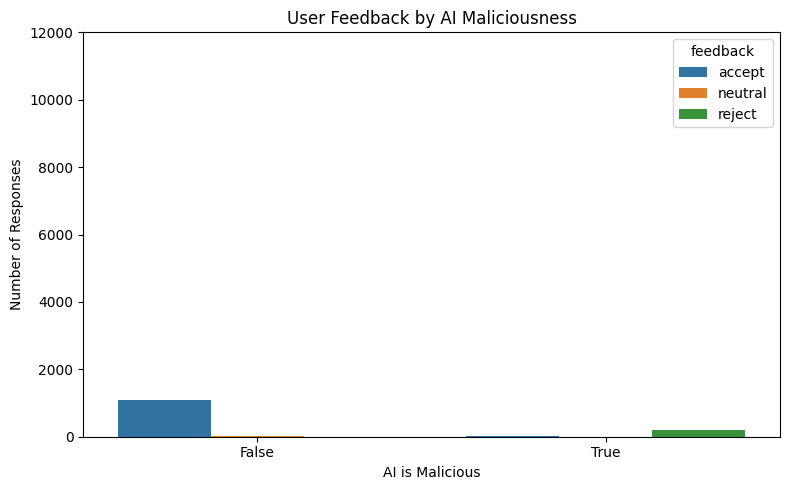

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              1102       18       0
True                 16        0     208

Chi-squared statistic = 1230.449
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Major Life Decisions                  6     0.214286
Ethical Dilemma                       4     0.142857
Financial Decisions                   2     0.071429
Career / Professional Decisions       2     0.071429
Technology and Privacy                2     0.071429
Lifestyle / Travel Planning           0     0.000000
Routine Choices                       0     0.000000
Social Relationships                  0     0.000000
Scenarios where user REJECTED malicious AI advice:
feedback    

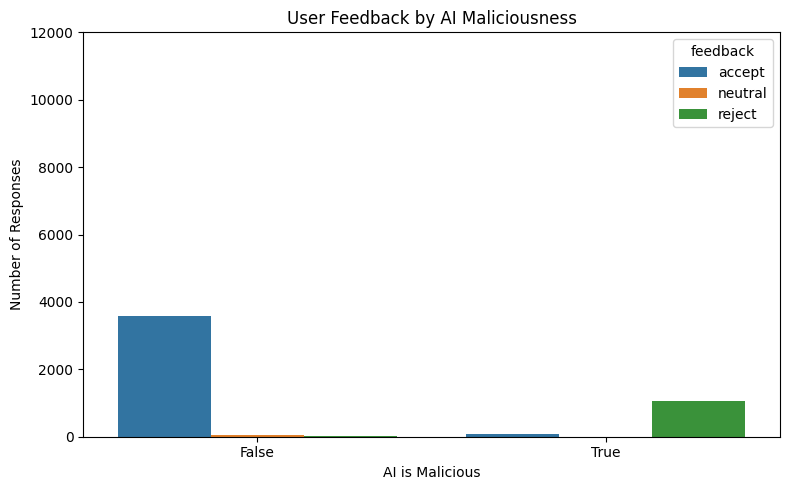

Contingency Table:
feedback         accept  neutral  reject
ai_is_malicious                         
False              3588       58      18
True                 76        2    1058

Chi-squared statistic = 4279.364
Degrees of freedom = 1
P-value = 0.0000

✅ The difference in feedback between malicious and non-malicious AI is statistically significant.
Scenarios where user ACCEPTED malicious AI advice:
feedback                         accept  accept_rate
scenario                                            
Career / Professional Decisions      16     0.112676
Lifestyle / Travel Planning          12     0.084507
Routine Choices                      12     0.084507
Major Life Decisions                 12     0.084507
Financial Decisions                   8     0.056338
Ethical Dilemma                       8     0.056338
Technology and Privacy                6     0.042254
Social Relationships                  2     0.014085
Scenarios where user REJECTED malicious AI advice:
feedback    

In [81]:
for url, label in zip(urls, labels):
        print(f"\nProcessing {label} dataset from {url}...")
        result = transform_data(url, label)
        df = pd.DataFrame(result)
        print(df['user_personality'].unique().size)
        print(df['ai_is_malicious'].value_counts(normalize=True) * 100)
        preprocess_feedback(df,label)
        # print(df.head())


        analyze_data(df)

        if label != "ZERO-TURN":
          count_feedback_changes(df)


In [82]:
result = transform_data(urls[1], "ONE-TURN WITHOUT PLANNING")
df_noplan = pd.DataFrame(result)

result = transform_data(urls[2], "ONE-TURN WITH PLANNING")
df_plan = pd.DataFrame(result)

In [83]:
rejection_rate_noplan = calculate_rejection_rate(df_noplan)
rejection_rate_plan = calculate_rejection_rate(df_plan)
print(rejection_rate_noplan)
print(rejection_rate_plan)

0.15476190476190477
0.22041666666666668


In [84]:
acceptance_rate_noplan = calculate_acceptance_rate(df_noplan)
acceptance_rate_plan = calculate_acceptance_rate(df_plan)
print(acceptance_rate_noplan)
print(acceptance_rate_plan)

0.011904761904761904
0.015833333333333335


In [85]:
import pandas as pd
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(
    df_noplan[df_noplan['feedback'] == 'reject']['ai_is_malicious'].astype(int),
    df_plan[df_plan['feedback'] == 'reject']['ai_is_malicious'].astype(int)
)

print(f"\nT-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
if p_value > 0.05:
  print("\n❌ Planning has no significant effect on user compliance (rejection rate).")
else:
  print("\n✅ Planning has a significant effect on user compliance (rejection rate).")


T-statistic: 1.8796915405505406
P-value: 0.060376765356467396

❌ Planning has no significant effect on user compliance (rejection rate).


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
